This example demonstrates the use of the cross-validation and the generalized matrix Rayleigh quotient (GMRQ) for selecting
MSM hyperparameters. The GMRQ is a criterion which "scores" how well the MSM eigenvectors generated on the training dataset
serve as slow coordinates for the test dataset [1].

[1] McGibbon, R. T. and V. S. Pande, [Variational cross-validation of slow dynamical modes in molecular kinetics](http://arxiv.org/abs/1407.8083) (2014)

In [7]:
from __future__ import print_function
import numpy as np
from msmbuilder.example_datasets import load_doublewell
from msmbuilder.cluster import NDGrid
from msmbuilder.msm import MarkovStateModel
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold

This example uses the doublewell dataset, which consists of ten trajectories in 1D with $x \in [-\pi, \pi]$.

In [8]:
trajectories = load_doublewell(random_state=0).trajectories
# sub-sample a little bit, by taking only every 100th data point in each trajectory.
trajectories = [t[::100] for t in trajectories]
print([t.shape for t in trajectories])

loading "/home/gerry/msmbuilder_data/doublewell/version-1_random-state-0.pkl"...
[(1001, 1), (1001, 1), (1001, 1), (1001, 1), (1001, 1), (1001, 1), (1001, 1), (1001, 1), (1001, 1), (1001, 1)]


A `pipeline` is a way of connecting together multiple estimators, so that we can create a custom model that
performs a sequence of steps. This model is relatively simple. It will first discretize the trajectory data
onto an evenly spaced grid between $-\pi$ and $\pi$, and then build an MSM.

In [9]:
model = Pipeline([
    ('grid', NDGrid(min=-np.pi, max=np.pi)),
    ('msm', MarkovStateModel(n_timescales=1, lag_time=1, reversible_type='transpose', verbose=False))
])

## Cross validation 

To get an accurate indication of how well our MSMs are doing at finding the dominant eigenfunctions
of our stochastic process, we need to consider the tendenancy of statistical models to overfit their
training data. Our MSMs might build transition matrices which fit the noise in training data as opposed
to the underlying signal.

One way to combat overfitting in a data-efficient way is with cross validation. This example uses 5-fold
cross valiation.

In [10]:
def fit_and_score(trajectories, model, n_states):
    cv = KFold(len(trajectories), n_folds=5)
    results = []

    for n in n_states:
        model.set_params(grid__n_bins_per_feature=n)
        for fold, (train_index, test_index) in enumerate(cv):
            train_data = [trajectories[i] for i in train_index]
            test_data = [trajectories[i] for i in test_index]

            # fit model with a subset of the data (training data).
            # then we'll score it on both this training data (which
            # will give an overly-rosy picture of its performance)
            # and on the test data.
            model.fit(train_data)
            train_score = model.score(train_data)
            test_score = model.score(test_data)

            results.append({
                'train_score': train_score,
                'test_score': test_score,
                'n_states': n,
                'fold': fold})
    return results

In [11]:
results = fit_and_score(trajectories, model, [5, 10, 25, 50, 100, 200, 500, 750])

In [12]:
import pandas as pd
results = pd.DataFrame(results)
results.head()

,fold,n_states,test_score,train_score
0,0,5,1.980255,1.965947
1,1,5,1.974135,1.967516
2,2,5,1.959164,1.970776
3,3,5,1.962523,1.969898
4,4,5,1.963001,1.970182


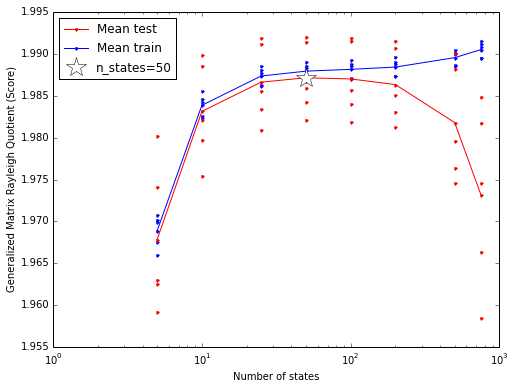

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(results['n_states'], results['train_score'], c='b', marker='.', ls='')
plt.plot(results['n_states'], results['test_score'], c='r', marker='.', ls='')

mean_over_folds = results.groupby('n_states').aggregate(np.mean)
plt.plot(mean_over_folds.index, mean_over_folds['test_score'], c='r', marker='.', ls='-', label='Mean test')
plt.plot(mean_over_folds.index, mean_over_folds['train_score'], c='b', marker='.', ls='-', label='Mean train')
plt.semilogx()
plt.ylabel('Generalized Matrix Rayleigh Quotient (Score)')
plt.xlabel('Number of states')

best_n_states = np.argmax(mean_over_folds['test_score'])
best_test_score = mean_over_folds.ix[best_n_states]['test_score']
plt.plot(best_n_states, best_test_score, marker='*', ms=20, c='w', label='n_states=%d' % best_n_states)

plt.legend(loc='best', numpoints=1)
plt.show()

This plot is very similar to figure 1 from [McGibbon and Pande](http://arxiv.org/abs/1407.8083). It shows
that the performance on the training set keeps going up as we increase the number of states (with the
amount of data fixed), whereas the test performance peaks and then starts going down.

We should pick the model with the highest average test set performance. In this example, we're only choosing over
the number of MSMs states, but this method can also be used to evaluate the clustering method and any pre-processing
like tICA.

However, you do need to fix the number of dynamical processes to "score" (this is the `n_timescales` attribute for `MarkovStateModel`), as well as the lag time.